In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

import clmm
import numpy as np
from numpy import random
from clmm import Cosmology
from clmm.support import mock_data as mock
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

In [2]:
np.random.seed(0)
# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 5e-2  # True ellipticity standard variation
photoz_noise  = 5e-2
ndata         = 1000

# Create galaxy catalog and Cluster object

def create_nc_data_cluster_wll (theta, g_t, z_source, z_cluster, cosmo, dist, sigma_z = None, sigma_g = None):
    r = clmm.convert_units (theta, "radians", "Mpc", redshift = z_cluster, cosmo = cosmo)
    obs = Ncm.Matrix.new (len (theta), 3)

    for i in range (len (theta)):
        obs.set (i, 0, r[i])
        obs.set (i, 1, z_source[i])
        obs.set (i, 2, g_t[i])

    # gsdp  = Nc.GalaxySDPositionFlat ()
    gsdp  = Nc.GalaxySDPositionSRDY1 ()
    gsdzp = Nc.GalaxySDZProxyGauss ()
    gsds  = Nc.GalaxySDShapeGauss ()

    gsdp.set_z_lim (Ncm.Vector.new_array ([0.41, 4.1]))
    gsdp.set_r_lim (Ncm.Vector.new_array ([0.6, 3.2]))
    gsdzp.set_z_lim (Ncm.Vector.new_array ([0.4, 4.1]))
    gsdzp.set_sigma (sigma_z)
    gsds.set_sigma (sigma_g)

    gwll = Nc.GalaxyWLLikelihood (s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)
    gwll.set_obs (obs)
    gwll.set_ndata (ndata)
    gwll.set_cut (z_cluster + 0.1, 2.4, 0.75, 3.0)

    ga = Ncm.ObjArray.new ()
    ga.add (gwll)

    dcwll = Nc.DataClusterWLL (galaxy_array=ga, z_cluster=z_cluster)
    dcwll.set_init (True)
    
    return dcwll, gwll

def create_fit_obj (data_array, mset):
    dset = Ncm.Dataset.new ()
    for data in data_array:
        dset.append_data (data)
    lh = Ncm.Likelihood.new (dset)
    fit = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_FORWARD)

    return fit

In [3]:
moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)
mset = moo.get_mset ()

MDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:log10MDelta")
cDelta_pi = mset.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

data = mock.generate_galaxy_catalog (cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec, photoz_sigma_unscaled=photoz_noise)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
gc.compute_tangential_and_cross_components(geometry="flat")

ggt, gwll = create_nc_data_cluster_wll (gc.galcat['theta'], gc.galcat['et'], gc.galcat['z'], cluster_z, cosmo, cosmo.dist, sigma_z=photoz_noise, sigma_g=shapenoise)
fit = create_fit_obj ([ggt], mset)


In [4]:
fit.run (Ncm.FitRunMsgs.SIMPLE)
fit.obs_fisher ()
fit.log_info ()
fit.log_covar ()

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#.......................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:07.5563140
#  iteration            [000149]
#  function evaluations [000151]
#  gradient evaluations [000000]
#  degrees of freedom   [009998]
#  m2lnL     =    -653.844187024036 (    -653.84419 )
#  Fit parameters:
#     2.7159695331357      15.0559663978474    
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterWLL
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model para

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      12
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0200.
#   Number of threads: 0012.
#   Using MPI:         no - use MPI enabled but no slaves available.
# NcmFitESMCMC: No RNG was defined, using algorithm: `mt19937' and seed: 1862655748.
# NcmMSetCatalog: Current mean:  -726          2.7166       15.055     
# NcmMSetCatalog: Current msd:    1.3095       0.00067165   0.0036187  
# NcmMSetCatalog: Current sd:     18.519       0.0094985    0.051176   
# NcmMSetCatalog: Current var:    342.97       9.0222e-05   0.002619   
# NcmMSetCatalog: Current tau:    1            1            1          
# NcmMSetCatalog: Current skfac: -nan         -nan         -nan        
# NcmMSetCatalog: Maximal Shrink factor = 1e+10 

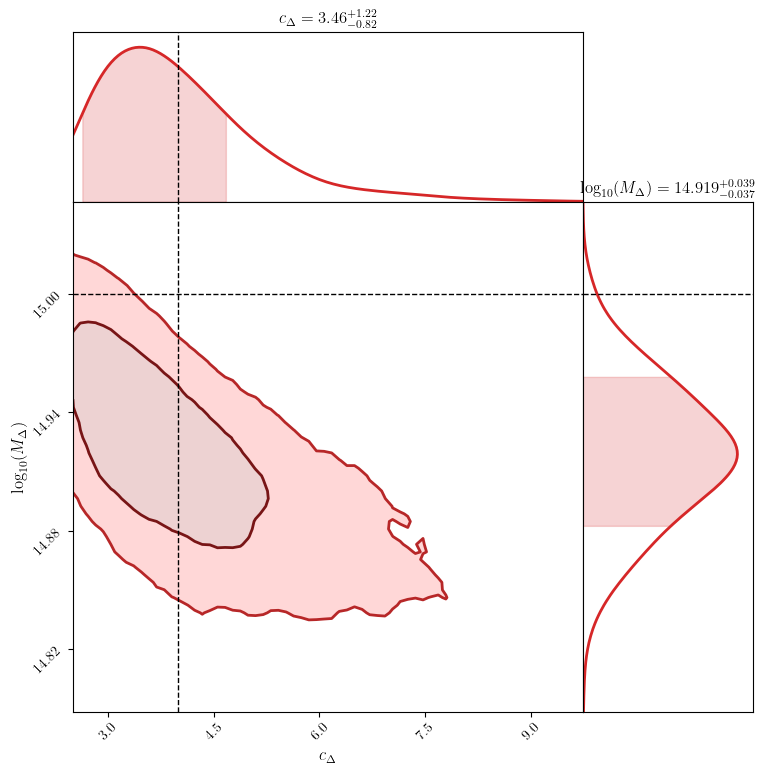

In [5]:
Ncm.func_eval_set_max_threads (12)
Ncm.func_eval_log_pool_stats ()

init_sampler = Ncm.MSetTransKernGauss.new (0)
init_sampler.set_mset (mset)
init_sampler.set_prior_from_mset ()
init_sampler.set_cov_from_rescale (1.0e-1)

nwalkers = 200
stretch = Ncm.FitESMCMCWalkerAPES.new (nwalkers, mset.fparams_len ())
esmcmc  = Ncm.FitESMCMC.new (fit, nwalkers, init_sampler, stretch, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_auto_trim_div (100)
esmcmc.set_max_runs_time (2.0 * 60.0)
esmcmc.set_nthreads(12)
esmcmc.start_run ()
esmcmc.run (10000/nwalkers)
esmcmc.end_run ()

mcat = esmcmc.peek_catalog ()
rows = np.array([mcat.peek_row(i).dup_array() for i in range(nwalkers * 10, mcat.len())])
params = ["$" + mcat.col_symb(i) + "$" for i in range (mcat.ncols())]

partial = ChainConsumer ()
partial.add_chain(rows[:,1:], parameters=params[1:], name=f"$\sigma_{{\epsilon^s}} = {shapenoise}$")
partial.configure(spacing=0.0, usetex=True, colors='#D62728', shade=True, shade_alpha=0.2, bar_shade=True, smooth=True, kde=True, legend_color_text=False, linewidths=2)

CC_fig = partial.plotter.plot(figsize=(8, 8), truth=[4, 15])

fig = plt.figure(num=CC_fig, figsize=(8,8), dpi=300, facecolor="white")